<img align="center" src="https://sun9-60.userapi.com/impg/p3Y7_mxIo8o16iddDVtEOSf5jAJqrNtrINUCpw/UzPFVPGpu9Y.jpg?size=750x750&quality=95&sign=336e82f3e4a84ccf4f0123e45abef8a2&type=album" width="350"> 


## Команда пыльных мышек представляет

## Проект по Анализу данных на питоне

# Анализ пассажиропотока и других показателей московского метрополитена

#### Выполнено Деркач Ульяной и Ивановой Дарьей

#### Навигация
[Часть 1: Подготовка данных](#title1)  <br>
[Работа с таблицей 1](#title2)  <br>
[Работа с таблицей 2](#title3)  <br>
[Работа с таблицей 3](#title4)  <br>
[Проверка сопостовимости трех таблиц](#title5)  <br>

[Часть 2: Разведка](#title6)  <br>
[Замена недостающих значений](#title7)  <br>
[Создание новых признаков](#title8)  <br>
[Визуализация](#title9)  <br>
[Корреляционные связи](#title10)  <br>

[Часть 3: Гипотезы](#title11)  <br>
[Гипотеза 1](#title12)  <br>
[Гипотеза 2](#title13)  <br>

[Часть 4: Машинное обучение](#title14)  <br>
[Линейная регрессия](#title15)  <br>
[Метрики модели](#title16)  <br>

Все используемые библиотеки здесь:

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

## <a id="title1">Часть 1: Подготовка данных </a>
### <a id="title2"> Работа с таблицей 1. </a>

Для нашего исследования были отобраны три массива данных, представляющих собой агрегированную информацию о различных показателях московского метрополитена, его станций и линий. Давайте посмотрим на данные:

In [2]:
df_accu = pd.read_excel('accuracy.xlsx')
df_accu.head()

,Line,Year,Quarter,Precision,global_id,Line_en,Year_en,Quarter_en,Precision_en
0,Линия,Год,Квартал,Процент выполнения расписания (%),global_id,Line_en,Year_en,Quarter_en,Precision_en
1,Сокольническая линия,2021,I квартал,99.99,1139011455,NaN,NaN,NaN,NaN
2,Замоскворецкая линия,2021,I квартал,99.99,1139011456,NaN,NaN,NaN,NaN
3,Арбатско-Покровская линия,2021,I квартал,99.99,1139011457,NaN,NaN,NaN,NaN
4,Филёвская линия,2021,I квартал,99.99,1139011458,NaN,NaN,NaN,NaN


В таблице “accuracy.xlsx” содержится информация о точности выполнения расписания поездами Московского метрополитена на разных линиях метро по кварталам с 2021 по 2023 год включительно. Видно, что в исходных данных есть пустные столбцы. Избавимся от них.
Кроме того, для удобства уберем первую строку, дублирующую название столбцов на русском. Аналогичные преобразования сделаем и для других таблиц, но об этом подробнее ниже.

In [3]:
drop = ['global_id', 'Line_en',
       'Year_en', 'Quarter_en', 'Precision_en']

df_accu.drop(labels=drop, axis=1, inplace = True)
df_accu.drop(labels = 0, axis=0, inplace = True)

df_accu = df_accu.reset_index(drop=True)

Теперь в нашей таблице представлены следующие признаки:
- **Line** - содержит название линии метро
- **Year** - год, в котором был рассчитан показатель
- **Quarter** - квартал года, в котором был рассчитан показатель 
- **Precision** - точность выполнения расписания (непосредственный показатель)

Посмотрим на их формат и преобразуем в нужный там, где потребуется:

In [4]:
df_accu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Line       144 non-null    object
 1   Year       144 non-null    object
 2   Quarter    144 non-null    object
 3   Precision  144 non-null    object
dtypes: object(4)
memory usage: 4.6+ KB


In [5]:
df_accu['Precision'] = df_accu['Precision'].astype(float)

Так как точность выполнения расписания высокая на каждой линии, мы решили отнормировать этот показатель с помощью минимаксной нормализации. Полученные значения были добавлены в столбец Precision_normalized. Теперь точность выполнения стало чуть легче сравнивать.

In [6]:
scaler = MinMaxScaler()
df_accu['Precision_normalized'] = scaler.fit_transform(df_accu[['Precision']])
df_accu.head()

,Line,Year,Quarter,Precision,Precision_normalized
0,Сокольническая линия,2021,I квартал,99.99,0.947368
1,Замоскворецкая линия,2021,I квартал,99.99,0.947368
2,Арбатско-Покровская линия,2021,I квартал,99.99,0.947368
3,Филёвская линия,2021,I квартал,99.99,0.947368
4,Кольцевая линия,2021,I квартал,99.99,0.947368


На этом подготовка первой таблицы закончена.
Перейдем к следующей:

### <a id="title3"> Работа с таблицей 2. </a>

In [7]:
df_traffic = pd.read_excel('passenger_traffic.xlsx')
df_traffic.head()

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id,NameOfStation_en,Line_en,Year_en,Quarter_en,IncomingPassengers_en,OutgoingPassengers_en
0,Станция метрополитена,Линия,Год,Квартал,Входы пассажиров,Выходы пассажиров,global_id,NameOfStation_en,Line_en,Year_en,Quarter_en,IncomingPassengers_en,OutgoingPassengers_en
1,Митино,Арбатско-Покровская линия,2021,I квартал,1913498,1829031,1138975996,NaN,NaN,NaN,NaN,NaN,NaN
2,Волоколамская,Арбатско-Покровская линия,2021,I квартал,1236714,1222309,1138975997,NaN,NaN,NaN,NaN,NaN,NaN
3,Строгино,Арбатско-Покровская линия,2021,I квартал,1938816,1903731,1138975999,NaN,NaN,NaN,NaN,NaN,NaN
4,Крылатское,Арбатско-Покровская линия,2021,I квартал,1849616,1818208,1138976000,NaN,NaN,NaN,NaN,NaN,NaN


Таблица “passenger_traffic.xlsx” содержит информацию о пассажиропотоке (так называемой загруженности) станций Московского метрополитена (станции также сгруппированы по линиям) с 2021 по 2023 год включительно. Признаки следующие:
- **NameOfStation** - название станции метро
- **Line** - линия метрополитена, к которой относится станция 
- **Year** - год, в котором был рассчитан показатель
- **Quarter** - квартал года, в котором был рассчитан показатель
- **IncomingPassengers** - количество пассажиров, вошедших через турникеты на этой станции метро
- **OutgoingPassengers** - количество пассажиров, вышедших на этой станции метро

In [8]:
dropp = ['global_id', 'NameOfStation_en', 'Line_en', #так же удалили пустые столбцы и первую строку
       'Year_en', 'Quarter_en', 'IncomingPassengers_en',
       'OutgoingPassengers_en']
df_traffic.drop(labels=dropp, axis=1, inplace = True)
df_traffic.drop(labels = 0, axis=0, inplace = True)
df_traffic = df_traffic.reset_index(drop=True)

In [9]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520 entries, 0 to 2519
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   NameOfStation       2520 non-null   object
 1   Line                2520 non-null   object
 2   Year                2520 non-null   object
 3   Quarter             2520 non-null   object
 4   IncomingPassengers  2520 non-null   object
 5   OutgoingPassengers  2520 non-null   object
dtypes: object(6)
memory usage: 118.2+ KB


In [10]:
df_traffic[['IncomingPassengers', 'OutgoingPassengers']] = df_traffic[['IncomingPassengers', 'OutgoingPassengers']].astype(int)

Удалили лишние, отформатировали. 

In [11]:
df_traffic.head()

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers
0,Митино,Арбатско-Покровская линия,2021,I квартал,1913498,1829031
1,Волоколамская,Арбатско-Покровская линия,2021,I квартал,1236714,1222309
2,Строгино,Арбатско-Покровская линия,2021,I квартал,1938816,1903731
3,Крылатское,Арбатско-Покровская линия,2021,I квартал,1849616,1818208
4,Площадь Революции,Арбатско-Покровская линия,2021,I квартал,2324687,2319343


In [12]:
df_traffic.isnull().sum()

NameOfStation         0
Line                  0
Year                  0
Quarter               0
IncomingPassengers    0
OutgoingPassengers    0
dtype: int64

In [13]:
((df_traffic['IncomingPassengers'] | df_traffic['OutgoingPassengers']) == 0).sum()

70

Как видно **NaN**ов в таблице нет, но нули есть. Вряд ли какие-то станции не фунцкционировали в какой-то квартал. Скорее просто не было собрано данных за тот период. Так как в таблице `df_traffic` представлена информация по 9 кварталам практически для каждой станции, не хочется рушить такую закономерность, поэтому мы решили заменить эти нули на средней пассажиропоток за все кварталы по станции. Код смотри в "Часть 2: Разведка".

И наконец, посмотрим на последнюю (но не по важности) таблицу. 

### <a id="title4"> Работа с таблицей 3. </a>

In [14]:
df_info = pd.read_excel('info.xlsx')
df_info.head()

,Line,NumberOfStations,MetroLineLength,NumberOfCarriages,global_id,Line_en,NumberOfStations_en,MetroLineLength_en,NumberOfCarriages_en
0,Линия,Количество станций,Эксплуатационная длина (км),Количество вагонов,global_id,Line_en,NumberOfStations_en,MetroLineLength_en,NumberOfCarriages_en
1,Сокольническая линия,26,41.34,509,1138975976,NaN,NaN,NaN,NaN
2,Замоскворецкая линия,24,42.92,746,1138975977,NaN,NaN,NaN,NaN
3,Арбатско-Покровская линия,22,44.98,479,1138975978,NaN,NaN,NaN,NaN
4,Филёвская линия,13,14.53,162,1138975979,NaN,NaN,NaN,NaN


In [15]:
df_info.columns

Index(['Line', 'NumberOfStations', 'MetroLineLength', 'NumberOfCarriages',
       'global_id', 'Line_en', 'NumberOfStations_en', 'MetroLineLength_en',
       'NumberOfCarriages_en'],
      dtype='object')

In [16]:
droppp = ['global_id', 'Line_en', 'NumberOfStations_en', 'MetroLineLength_en',
       'NumberOfCarriages_en']
df_info.drop(labels=droppp, axis=1, inplace = True)
df_info.drop(labels = 0, axis=0, inplace = True)
df_info = df_info.reset_index(drop=True)

In [17]:
df_info[['NumberOfStations', 'NumberOfCarriages']] = df_info[['NumberOfStations', 'NumberOfCarriages']].astype(int)
df_info['MetroLineLength'] = df_info['MetroLineLength'].astype(float)
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Line               16 non-null     object 
 1   NumberOfStations   16 non-null     int64  
 2   MetroLineLength    16 non-null     float64
 3   NumberOfCarriages  16 non-null     int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 640.0+ bytes


Посмотрели. Удалили пустые. Перевели в другой формат.

In [18]:
df_info.head()

,Line,NumberOfStations,MetroLineLength,NumberOfCarriages
0,Сокольническая линия,26,41.34,509
1,Замоскворецкая линия,24,42.92,746
2,Арбатско-Покровская линия,22,44.98,479
3,Филёвская линия,13,14.53,162
4,Кольцевая линия,12,19.17,280


### <a id="title5"> Проверка сопостовимости трех таблиц. </a>

Все наши таблицы объединяет одна вещь (помимо этих двух: то, что они таблицы, то, что информация касается метро) – это линии. По значениям различных признаков для линий мы и будем сопостовлять таблицы. Но для начала проверим, что во всех таблицах линии одинаковы.

In [19]:
set(df_info['Line'].unique()) - set(df_accu['Line'].unique())

set()

In [20]:
set(df_traffic['Line'].unique()) - set(df_info['Line'].unique())

{'Каховская линия'}

в `df_traffic` есть шальная линия "Каховская". Удалим ее, так как по ней нет данных в других таблицах.

In [21]:
df_traffic[df_traffic['Line'] == 'Каховская линия']


,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers
800,Каширская,Каховская линия,2021,III квартал,0,0


In [22]:
df_traffic.drop(index=800, inplace=True)
df_traffic = df_traffic.reset_index(drop=True)
df_traffic.head()

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers
0,Митино,Арбатско-Покровская линия,2021,I квартал,1913498,1829031
1,Волоколамская,Арбатско-Покровская линия,2021,I квартал,1236714,1222309
2,Строгино,Арбатско-Покровская линия,2021,I квартал,1938816,1903731
3,Крылатское,Арбатско-Покровская линия,2021,I квартал,1849616,1818208
4,Площадь Революции,Арбатско-Покровская линия,2021,I квартал,2324687,2319343


## <a id="title6">Часть 2: Разведка </a>

### <a id="title7"> Замена недостающих значений. </a>

В ходе работы над проектом мы пытались заменить нули в датасете на среднее по каждой станции, что не вышло должным образом. Поэтому мы заменили нули на среднее входящих и выходящих пассажиров по всем станциям по всем периодам. Предварительно, мы проанализировали станции, у которых были нули, и замена на указанное среднее сопоставимо с данными и не образует выбросов.

In [23]:
df_traffic = df_traffic.replace(0, np.nan)
in_mean = df_traffic['IncomingPassengers'].mean()
out_mean = df_traffic['OutgoingPassengers'].mean()

df_traffic.fillna(in_mean, inplace=True)
df_traffic.fillna(out_mean, inplace=True)
(df_traffic['IncomingPassengers'] == 0).sum()

0

### <a id="title8"> Создание новых признаков. </a>

В таблице `df_traffic` имеется две колонки для указания периода, что значительно усложняет поиск и агрегацию информации, поэтому мы решили добавить новый признак и закодировать в него период (квартал и год).

In [24]:
df_traffic['Period'] = 0
#знаем, можно было как-то соптимизировать код, но иногда простой путь самый лучший
df_traffic.loc[(df_traffic['Year'] == '2021') & (df_traffic['Quarter'] == 'I квартал'), 'Period'] = 1
df_traffic.loc[(df_traffic['Year'] == '2021') & (df_traffic['Quarter'] == 'II квартал'), 'Period'] = 2
df_traffic.loc[(df_traffic['Year'] == '2021') & (df_traffic['Quarter'] == 'III квартал'), 'Period'] = 3
df_traffic.loc[(df_traffic['Year'] == '2021') & (df_traffic['Quarter'] == 'IV квартал'), 'Period'] = 4

df_traffic.loc[(df_traffic['Year'] == '2022') & (df_traffic['Quarter'] == 'I квартал'), 'Period'] = 5
df_traffic.loc[(df_traffic['Year'] == '2022') & (df_traffic['Quarter'] == 'II квартал'), 'Period'] = 6
df_traffic.loc[(df_traffic['Year'] == '2022') & (df_traffic['Quarter'] == 'III квартал'), 'Period'] = 7
df_traffic.loc[(df_traffic['Year'] == '2022') & (df_traffic['Quarter'] == 'IV квартал'), 'Period'] = 8

df_traffic.loc[(df_traffic['Year'] == '2023') & (df_traffic['Quarter'] == 'I квартал'), 'Period'] = 9

df_traffic.head()

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,Period
0,Митино,Арбатско-Покровская линия,2021,I квартал,1913498.0,1829031.0,1
1,Волоколамская,Арбатско-Покровская линия,2021,I квартал,1236714.0,1222309.0,1
2,Строгино,Арбатско-Покровская линия,2021,I квартал,1938816.0,1903731.0,1
3,Крылатское,Арбатско-Покровская линия,2021,I квартал,1849616.0,1818208.0,1
4,Площадь Революции,Арбатско-Покровская линия,2021,I квартал,2324687.0,2319343.0,1


In [25]:
df_info.set_index('Line', inplace=True)

Для начала подсчитаем среднее количество входящих и выходящих пассажиров за 9 перидов (4 квартала 2021 года, 4 квартала 2022 года, 1 квартал 2023 года), а также среднюю точность выполнения расписания. Добавим новые признаки в `df_info`:

In [26]:
df_info['MeanOfIncoming'] = df_traffic.groupby('Line')['IncomingPassengers'].mean().round(2)
df_info['MeanOfOutgoing'] = df_traffic.groupby('Line')['OutgoingPassengers'].mean().round(2)
df_info['MeanPrecision'] = df_accu.groupby('Line')['Precision_normalized'].mean().round(4)
df_info.head()

,NumberOfStations,MetroLineLength,NumberOfCarriages,MeanOfIncoming,MeanOfOutgoing,MeanPrecision
Line,,,,,,
Сокольническая линия,26,41.34,509,1895961.59,1882919.27,0.9474
Замоскворецкая линия,24,42.92,746,2647253.22,2607165.14,0.9474
Арбатско-Покровская линия,22,44.98,479,2563367.76,2542389.32,0.9649
Филёвская линия,13,14.53,162,922255.35,926943.17,0.9591
Кольцевая линия,12,19.17,280,2958932.40,2869819.34,0.7836


### <a id="title9"> Визуализация. </a>

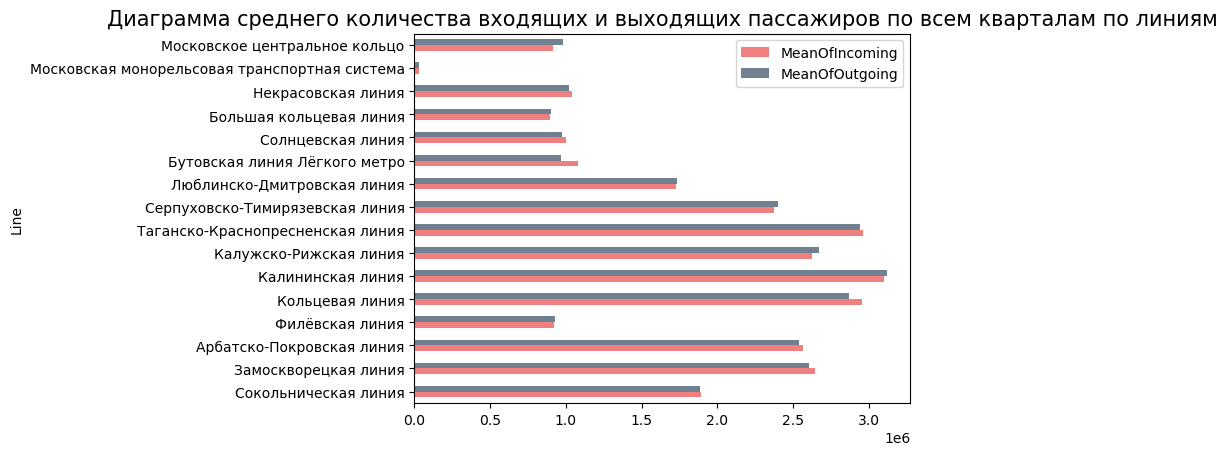

In [27]:
df_info[['MeanOfIncoming','MeanOfOutgoing']].plot.barh(color={'MeanOfIncoming':'lightcoral', 'MeanOfOutgoing':'slategrey' })
plt.title('Диаграмма среднего количества входящих и выходящих пассажиров по всем кварталам по линиям', fontsize=15);

На графике видно, что среднее количество входящих на каждой станции пассажиров прмерно равно среднему выходящих. Кроме того, можно легко определить лидеров по пассажиропотоку – это Калининская, Таганско-Краснопресненская, Кольцевая линии. Меньше всего популярна монорельсовая траспортная система.  <br>
В целом, график дает представления о загруженности тех или иных линий. Интересно то, что такая инфографика загруженности соответсвует нашему личному опыту использования метро.


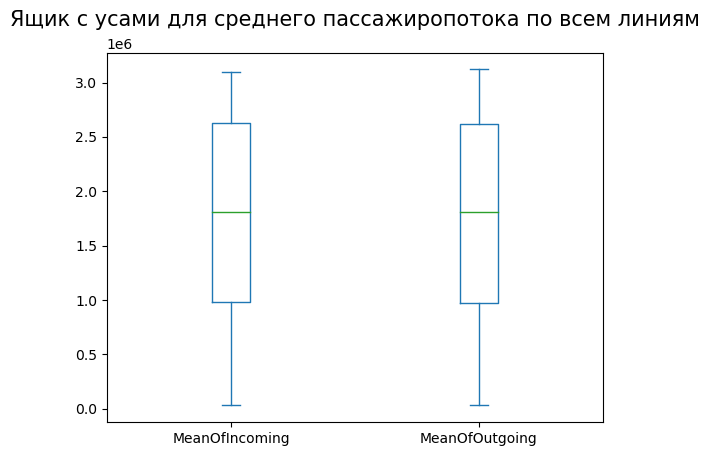

In [28]:
df_info[['MeanOfIncoming', 'MeanOfOutgoing']].plot.box()
ax = plt.gca() 
ax.set_title("Ящик с усами для среднего пассажиропотока по всем линиям",  fontsize=15, y=1.05);

На данном графике мы рассмотрели показатели входящего и выходящего пассажиропотока таблицы 'df_info' . Целью построения было удостовериться, что выборка из средних значений по станциям околонормальна и не имеет ярких выбросов, то есть будет статистически значима для дальнейшей интерпретации.

Мы хотим посмотреть на распределение среднего количества входящих и выходящих пассажиров на каждой ветке в зависимости от времени года.  Времена года мы интерпретируем так: 1,5,9 (первый квартал каждого года) = зима; 2,6 = весна; 3,7 = лето; 4,8 = осень. Разницу в средних, зависящую от времени года, будем использовать далее при составлении гипотезы. 

In [29]:
#перегруппируем данные, чтобы построить по ним нужный график
df_agg = df_traffic.groupby(['Line', 'Period'])[['IncomingPassengers','OutgoingPassengers']].agg('mean').round(2)
df_agg

IncomingPassengers  OutgoingPassengers
Line                      Period                                        
Арбатско-Покровская линия 1               2260458.76          2241140.94
                          2               2558199.35          2536397.72
                          3               2555866.70          2524631.05
                          4               2643675.55          2625269.05
                          5               2449992.95          2429940.77
...                                              ...                 ...
Филёвская линия           5                879477.06           881484.60
                          6                958604.44           964392.52
                          7                941086.06           948793.14
                          8               1000188.44          1009075.91
                          9                914657.52           918286.14

[144 rows x 2 columns]

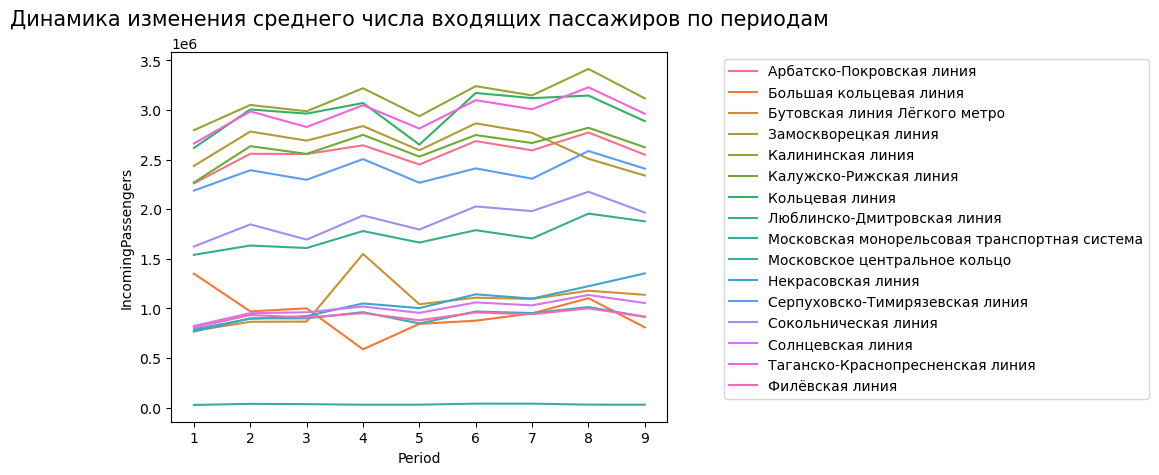

In [30]:
df_use = df_agg.reset_index(drop=False)
sns.lineplot(
    data=df_use,
    y="IncomingPassengers", x="Period", hue="Line", linewidth=1.5, 
)
plt.legend().set_bbox_to_anchor((1.1, 1))

ax = plt.gca() 
ax.set_title("Динамика изменения среднего числа входящих пассажиров по периодам", y=1.05, fontsize=15);


По визуализации на диаграмме видно, что распределение среднего числа пассажиров для каждой линии метро держит примерно одинаковый уровень (разумеется, с флуктуациями). Заметим также, что практически для всех линий верно, что зимой (1, 5, 9 периоды) наблюдаются меньшие значения пассажиропотока, весной (2,6) и летом (3,7) значения примерно одинаковые, а в 4 и 8 периодах (в нашей интерпретации это осень) повышается число входящих пассажиров.  <br>
Выводы, полученные по этому графику, мы хотим проверить статистически. Для этого мы будем тестировать гипотезы о равенстве математических ожиданий потока зимой и летом, осенью и весной.

### <a id="title10"> Корреляционые связи. </a>

Найдем всевозможные корреляционные связи между переменными, для этого посмотрим корреляционную матрицу и визуализируем ее.

In [31]:
df_info_corr = df_info.corr(method='pearson')
df_info_corr

,NumberOfStations,MetroLineLength,NumberOfCarriages,MeanOfIncoming,MeanOfOutgoing,MeanPrecision
NumberOfStations,1.000000,0.899481,0.749077,0.297847,0.321912,-0.006674
MetroLineLength,0.899481,1.000000,0.798719,0.240902,0.262036,-0.018219
NumberOfCarriages,0.749077,0.798719,1.000000,0.511430,0.525075,-0.016037
MeanOfIncoming,0.297847,0.240902,0.511430,1.000000,0.998944,-0.511187
MeanOfOutgoing,0.321912,0.262036,0.525075,0.998944,1.000000,-0.496263
MeanPrecision,-0.006674,-0.018219,-0.016037,-0.511187,-0.496263,1.000000


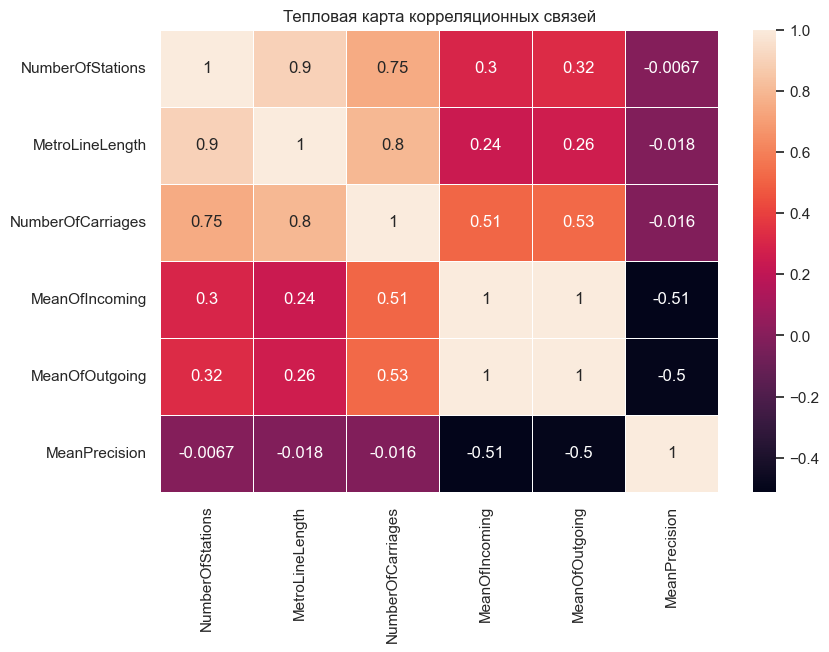

In [32]:
import seaborn as sns
sns.set_theme()

f, ax = plt.subplots(figsize=(9, 6))
plt.title('Тепловая карта корреляционных связей')
sns.heatmap(df_info_corr, annot=True, linewidths=.5, ax=ax);

Изначально у нас была гипотеза, что чем выше загруженность ветки, тем больше на ней курсируют вагоны и тем меньше точность выполнения расписания на линии, так как большой пассажиропоток может задерживать состав на станции, а значит на следующую станцию он приедет с опозданием, что сбивает расписание.   <br>

Наши предположения подтвердились корреляционным анализом: действительно, имеется существенная положительная зависимость между количеством курсирующих вагонов и заходящих/выходящих на линии пассажиров. Более того, наблюдается довольно-таки сильная отрицательная зависимость между показателями "точность выполнения расписания" и "количество входящих/выходящих пассажиров".  <br>

Заметим также то, что количество станций на ветке практически напрямую зависит от ее длины (корреляция = 0.9), а также количество курсирующих на ветке вагонов сильно зависит от длины и количества станций (корреляция = 0.8 и 0.75). Это говорит о том, что с увеличением количестваа пассажиров на линии, увеличивается состав вагонов. Это связано не только с необходимостью соблюдения расписания на всей протяженности ветки, но и учетом  ее загруженности, т.е. предотвращением скопления толпы.  <br>

Таким образом, все показатели в таблице `df_info` взаимосвязаны, параметры подстраиваются под друг друга, чтобы "осилить" нагрузку пассажиропотока.

## <a id="title11">Часть 3: Гипотезы </a>

### <a id="title12"> Гипотеза 1. </a>

Исходя из выводов, полученных по последнему графику в разделе "Визуализация", мы решили проверить несколько гипотез.  <br>
Во-первых, наблюдение показало, что зимой средний пассажиропоток меньше, чем летом. Однако мы предполагали обратное, исходя из логики, что летом люди больше ходят пешком, предпочитают пользоваться наземным транспортом, так как этому располагает погода. Поэтому, проверим нулевую гипотезу о том, что средний пассажиропоток по всем станциям зимой равен среднему пассажиропотоку по всем станциям летом.  <br>
**Ремарка:** так как мы в целом уже оценили, что количество входящих примерно равно количеству выходящих, то здесь и дальше (в машинном обучении) будем рассматривать только показатель количества входящих пассажиров, т.е. `IncomingPassengers`. 

***H0:*** математическое ожидание пассажиропотока летом (3,7 период) равно математическому ожиданию зимнего пассажиропотока (1,5,9 периоды). 

***H1:*** математическое ожидание пассажиропотока летом больше математического ожидания зимнего пассажиропотока.

Мы планируем проверить эту гипотезу через построение доверительного интервала разницы математических ожиданий.

$$
\begin{aligned}
& H_0: \mu_{summer} = \mu_{winter} \\
& H_1: \mu_{summer}\ > \mu_{winter}
\end{aligned}
$$

In [33]:
#создадим наши выборки
summer = df_traffic[df_traffic['Period'].isin([3,7])]['IncomingPassengers']
winter = df_traffic[df_traffic['Period'].isin([1,5,9])]['IncomingPassengers']

Оценим выборки:

In [34]:
print( "Среднее зимой:", round(winter.mean()),  'Медиана зимой:', winter.median())
print( "Среднее летом:", round(summer.mean()),  'Медиана летом:', summer.median())

Среднее зимой: 1819430 Медиана зимой: 1584097.0
Среднее летом: 1926895 Медиана летом: 1655375.0


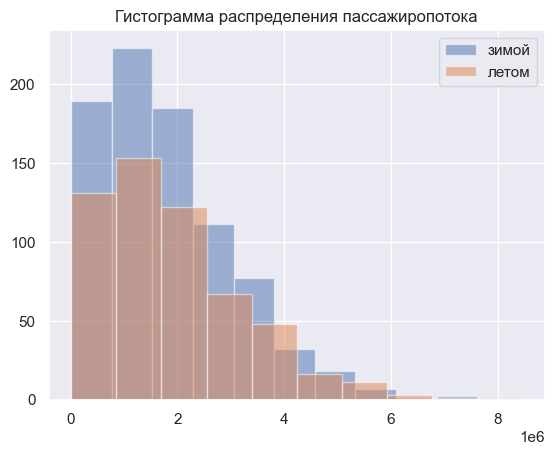

In [35]:
winter.hist(alpha = 0.5), summer.hist(alpha = 0.5)
plt.legend(['зимой', 'летом'])
plt.title('Гистограмма распределения пассажиропотока');

Видно, что медиана и среднее сильно отличаются для обеих выборок. Это говорит о наличии существенных выбросов. Что так же видно по гистограммам, распределение не очень похоже на нормальное, поэтому ЦПТ может сломаться.  <br>

Мы решили все-таки рискнуть и сделать t-тест для проверки гипотезы. Мы понимаем, что из-за наличия выбросов нужно с осторожностью отнестить к результатам этого теста.

In [36]:
sts.ttest_ind(summer, winter, equal_var=False, alternative = 'greater')

Ttest_indResult(statistic=1.5321266934923568, pvalue=0.0628857484223482)

По результатам теста p-value ≈ 0.06, можно сделать следующий вывод: на уровне значимости 5% нулевая гипотеза не отвергается, то есть средний пассажиропоток в зимний период не больше пассажиропотока в летний период (что не опровергает наше предположение о хорошей погоде).  <br>  
На уровне значимости 10% нулевая гипотеза отвергается, а значит летом на метро ездит больше пассажиров чем летом (это подтверждает наш вывод, сделанный по графику).

"Ненормальность" распределения нас все-таки настораживала, поэтому мы решили также провести тест Манна-Уитни, с нулевой гипотезой о том, что в летний и зимний периоды распределение пассажиров совпадает, и альтернативной гипотезой что не совпадает, или, согласно смыслу теста Манна-Уитни, распределение в зимний период "сдвинуто" относительно распределения в летний период.

In [37]:
U, pval = sts.mannwhitneyu(summer, winter, alternative='greater')
pval

0.08898887615374662

Тест Манна-Уитни показал, что на уровне значимости 5% нулевая гипотеза не отвергается, т.е. распределения совпадают. На уровне значимости 10% нулевая гипотеза отвергается.  <br> 
В целом, по общей логике результаты обоих тестов совпали, в зависимости от уровня значимости (5% или 10%) нулевая гипотеза не отвергается/отвергается.  <br> 


### <a id="title13"> Гипотеза 2. </a>

Мы решили проделать ту же процедуру для пассажиропотоков весной и осенью:

In [38]:
autumn = df_traffic[df_traffic['Period'].isin([4,8])]['IncomingPassengers']
spring = df_traffic[df_traffic['Period'].isin([2,6])]['IncomingPassengers']
sts.ttest_ind(autumn, spring, equal_var=False, alternative = 'greater')

Ttest_indResult(statistic=0.652584887145345, pvalue=0.25707898692599207)

In [39]:
U, pval = sts.mannwhitneyu(autumn, spring, alternative='greater')
pval

0.2670978027572708

В этом случае, при всех допустимых уровнях значимости (1%, 5%, 10%, 20%) нулевая гипотеза не отвергается, то есть средний пассажиропоток весной, такой же как и средний пассажиропоток осенью.

## <a id="title14"> Часть 4: Машинное обучение </a>


### <a id="title15"> Линейная регрессия. </a>

В этом разделе мы создаем и проверяем модель, которая будет предсказывать пассажиропоток для каждой станции. 

Работающая модель имеет следующий потенциал практического применения: если в среднем показатель агрегированного по ветке пассажиропотока имеет тенденцию к росту, то есть необходимость увеличения количества курсирующих на этой линии составов. 

In [40]:
#подготовим данные для модели
use = df_traffic.groupby(['Line', 'Period'])[['IncomingPassengers','OutgoingPassengers']].agg('mean').round(2).reset_index(drop=False)
lines = list(use['Line'].unique())
ml = pd.DataFrame(np.zeros((9,16)), columns=lines)
for i in range(len(lines)):
    cond = np.array(use[use['Line'] == lines[i]]['IncomingPassengers'])
    ml[lines[i]] = cond
ml=ml.T

Поделим наши данные на обучающую и тестовую выборки:

In [41]:
y = ml[8]
X = ml.drop(columns=[8])
feature_names = X.columns.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
model_regression = LinearRegression()
 
model_regression.fit(X_train, y_train)
#посмотрим на коэффициенты модели
model_regression.coef_, model_regression.intercept_

(array([-0.74270212, -0.3636875 ,  0.48744022,  0.10097512, -0.46600762,
         5.06102067, -4.36723879,  0.94821996]),
 -6384.178412832553)

Построим график распределения целевой переменной:

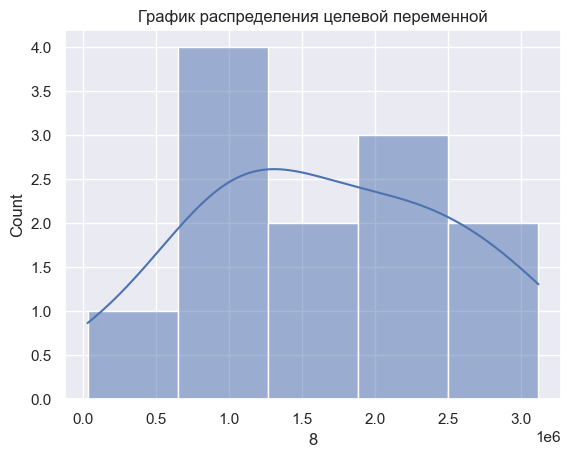

In [47]:
sns.histplot(y_train, kde=True)
plt.title('График распределения целевой переменной');

Распределение похоже на нормальное, нет статистически значимых выбросов, поэтому какая-либо предобработка перед анализом ошибок не требуется, все данные нумерические (численные).

### <a id="title16"> Метрики модели. </a>

Рассчитаем показатель средней абсолютной ошибки для наших прогнозируемых данных:

In [44]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.2261
Train MAPE = 0.0336


Показатель MAPE довольно высокий и составляет 22% на тестовой выборке, но так как в нашей модели не так много данных для обучения, это плюс минус приемлемый показатель.

Теперь рассмотрим качество полученной модели с помощью кросс-валидации: поделим обучающую выборку на n частей, затем обучим n моделей. Для получения более чистого финального значения метрики качества, мы усредним полученные нами n значений.

In [45]:
cv_scores = cross_val_score(model, X_train, y_train, 
                            cv=10, scoring='neg_mean_absolute_percentage_error')

print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -0.0595
	-0.3212
	-0.2625
	-0.0797
	-0.0199
	-0.0327
	-0.1151
	-0.4126
	-0.5296
	-0.0415
Mean CV MSE = 0.1874


Показатель MSE сравнительно небольшой, ошибки в среднем допускаются незначительных размеров (если анализировать, что в процентах они составляют 22%, а MSE = 0.18, можно прийти к такому логическому заключению).

Посчитаем статистику R^2 для наших данных:

In [46]:
print("Test R2 = %.4f" % r2_score(y_test, y_pred))
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))

Test R2 = 0.8287
Train R2 = 0.9992


Показатель R^2 имеет высокое значение, следовательно прогноз статистически значим.

Подводя итог, в результате проверки различными показателями, модель работает относительно стабильно и имеет потенциал к улучшению при расширении обучающей выборки, так как у нас она была не такой большой. Модель может в дальнейшем применяться для прогнозирования будущих значений пассажиропотока по веткам московского метрополитена и исходя из результатов предсказанных значений способствовать расчету необходимого количества курсирующих на ветке составов (в вагонах).